# Displaying the Timeline of the Scheduler

In [36]:
# Collect the logs of the events of scheduled pods
!kubectl get events -A --sort-by=.metadata.creationTimestamp --field-selector reason=Scheduled -o json > temp.log

In [37]:
# Loading event json
import json

# Plotting the timeline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [38]:
with open('temp.log', 'r') as file:
    data = json.load(file)

In [39]:
data

{'apiVersion': 'v1',
 'items': [{'action': 'Binding',
   'apiVersion': 'v1',
   'eventTime': '2025-04-03T14:54:08.172056Z',
   'firstTimestamp': None,
   'involvedObject': {'apiVersion': 'v1',
    'kind': 'Pod',
    'name': 'prometheus-deployment-7d9fd95489-b76gs',
    'namespace': 'monitoring',
    'resourceVersion': '9554349',
    'uid': '97d2400b-fa13-4b7d-9a3c-47fce78dbe86'},
   'kind': 'Event',
   'lastTimestamp': None,
   'message': 'Successfully assigned monitoring/prometheus-deployment-7d9fd95489-b76gs to dev-k8s-lc869-18',
   'metadata': {'creationTimestamp': '2025-04-03T14:54:08Z',
    'name': 'prometheus-deployment-7d9fd95489-b76gs.1832d6ade906fd69',
    'namespace': 'monitoring',
    'resourceVersion': '9554354',
    'uid': '100152cf-3838-41c0-b84e-3391895e400f'},
   'reason': 'Scheduled',
   'reportingComponent': 'default-scheduler',
   'reportingInstance': 'default-scheduler-dev-k8s-lc869-00',
   'source': {},
   'type': 'Normal'},
  {'action': 'Binding',
   'apiVersion':

In [40]:
# Filter out the scheduling events that weren't carried out by our scheduler
sched_name = 'central-sched'
basic_sched_events = [ x for x in data['items'] if  x['reportingComponent'] == sched_name]

In [41]:
# Select the most recent events
latest = 10
basic_sched_events = basic_sched_events[-10:]

In [42]:
basic_sched_events

[{'action': 'Binding',
  'apiVersion': 'v1',
  'eventTime': '2025-04-03T15:21:48.981965Z',
  'firstTimestamp': None,
  'involvedObject': {'kind': 'Pod',
   'name': 'pi-2000-l6ff6',
   'namespace': 'basic-sched',
   'uid': '580e35dc-18ee-4f5d-b477-130113d605e1'},
  'kind': 'Event',
  'lastTimestamp': None,
  'message': 'Successfully assigned basic-sched/pi-2000-l6ff6 to dev-k8s-lc869-13',
  'metadata': {'annotations': {'scheduler/nanoseconds': '10451655'},
   'creationTimestamp': '2025-04-03T15:21:48Z',
   'generateName': 'pi-2000-l6ff6-',
   'name': 'pi-2000-l6ff6-gvh4c',
   'namespace': 'basic-sched',
   'resourceVersion': '9560879',
   'uid': 'c652c1a1-8d69-4806-92f8-20e7f17d0ee1'},
  'reason': 'Scheduled',
  'reportingComponent': 'central-sched',
  'reportingInstance': 'central-sched-dev-k8s-lc869-00',
  'source': {},
  'type': 'Normal'},
 {'action': 'Binding',
  'apiVersion': 'v1',
  'eventTime': '2025-04-03T15:21:48.807776Z',
  'firstTimestamp': None,
  'involvedObject': {'kind': 

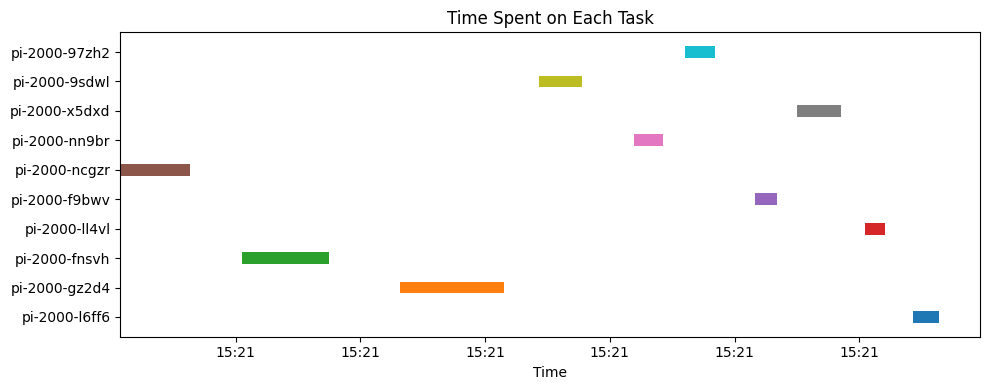

In [43]:
# Convert string timestamps to datetime objects and compute durations (in hours)
for event in basic_sched_events:
    event["end_dt"] = datetime.fromisoformat(event["eventTime"])
    event["duration"] = timedelta(microseconds= int(event['metadata']['annotations']['scheduler/nanoseconds']) / 1000)
    #event["start_dt"] = event["end_dt"] - duration_td

# Create the plot
fig, ax = plt.subplots(figsize=(10, 4))

# Plot each scheduling event as a horizontal bar
for i, event in enumerate(basic_sched_events):
    ax.barh(i, event["duration"], left = event["end_dt"] - event["duration"], height=0.4, align='center')

# Set y-axis with component names
ax.set_yticks(range(len(basic_sched_events)))
ax.set_yticklabels([event["involvedObject"]["name"] for event in basic_sched_events])

# Format the x-axis to show time (using hours and minutes)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Time")
plt.title("Time Spent on Each Task")
plt.tight_layout()
plt.show()


In [44]:
[(event["involvedObject"]["name"], event['metadata']['annotations']['scheduler/nanoseconds']) for event in basic_sched_events]

[('pi-2000-l6ff6', '10451655'),
 ('pi-2000-gz2d4', '41680556'),
 ('pi-2000-fnsvh', '34630652'),
 ('pi-2000-ll4vl', '8160582'),
 ('pi-2000-f9bwv', '9078370'),
 ('pi-2000-ncgzr', '28049415'),
 ('pi-2000-nn9br', '11357057'),
 ('pi-2000-x5dxd', '17644994'),
 ('pi-2000-9sdwl', '17099763'),
 ('pi-2000-97zh2', '11839383')]

In [45]:
[(event["involvedObject"]["name"], event['eventTime']) for event in basic_sched_events]

[('pi-2000-l6ff6', '2025-04-03T15:21:48.981965Z'),
 ('pi-2000-gz2d4', '2025-04-03T15:21:48.807776Z'),
 ('pi-2000-fnsvh', '2025-04-03T15:21:48.737299Z'),
 ('pi-2000-ll4vl', '2025-04-03T15:21:48.960330Z'),
 ('pi-2000-f9bwv', '2025-04-03T15:21:48.917199Z'),
 ('pi-2000-ncgzr', '2025-04-03T15:21:48.681813Z'),
 ('pi-2000-nn9br', '2025-04-03T15:21:48.871207Z'),
 ('pi-2000-x5dxd', '2025-04-03T15:21:48.942612Z'),
 ('pi-2000-9sdwl', '2025-04-03T15:21:48.838881Z'),
 ('pi-2000-97zh2', '2025-04-03T15:21:48.891966Z')]

# Pod Completion

In [20]:
!kubectl get pods -o json > pronto.json

In [22]:
import json
import statistics
from datetime import datetime

with open("pronto.json") as f:
    data = json.load(f)

durations = []

for pod in data["items"]:
    try:
        name = pod["metadata"]["name"]
        ns = pod["metadata"]["namespace"]
        start = datetime.fromisoformat(pod["status"]["startTime"].replace("Z", "+00:00"))

        # Get first container’s finished time
        cs = pod["status"]["containerStatuses"][0]
        if "terminated" in cs["state"]:
            finish = datetime.fromisoformat(cs["state"]["terminated"]["finishedAt"].replace("Z", "+00:00"))
            duration = (finish - start).total_seconds()
            durations.append((ns, name, duration))
    except Exception:
        continue

# Print results
for ns, name, dur in durations:
    print(f"{ns}/{name}: {dur:.2f} seconds")

dur = [d[2] for d in durations]
mean = statistics.mean(dur)
std_dev = statistics.stdev(dur)
print(f"Mean: {mean:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")

basic-sched/pi-2000-2gkcb: 8.00 seconds
basic-sched/pi-2000-2tdbm: 10.00 seconds
basic-sched/pi-2000-44dlp: 7.00 seconds
basic-sched/pi-2000-459n7: 6.00 seconds
basic-sched/pi-2000-4gmzz: 8.00 seconds
basic-sched/pi-2000-4h48z: 7.00 seconds
basic-sched/pi-2000-4wxwc: 5.00 seconds
basic-sched/pi-2000-4xk5f: 8.00 seconds
basic-sched/pi-2000-526gq: 9.00 seconds
basic-sched/pi-2000-52rf2: 10.00 seconds
basic-sched/pi-2000-5nkm6: 10.00 seconds
basic-sched/pi-2000-5xrwb: 10.00 seconds
basic-sched/pi-2000-66t8j: 10.00 seconds
basic-sched/pi-2000-69ksm: 9.00 seconds
basic-sched/pi-2000-6bljj: 10.00 seconds
basic-sched/pi-2000-6hf4l: 10.00 seconds
basic-sched/pi-2000-6hns7: 5.00 seconds
basic-sched/pi-2000-6kh55: 6.00 seconds
basic-sched/pi-2000-7459v: 7.00 seconds
basic-sched/pi-2000-74zsx: 8.00 seconds
basic-sched/pi-2000-77d4g: 7.00 seconds
basic-sched/pi-2000-7jb6m: 10.00 seconds
basic-sched/pi-2000-89b2m: 7.00 seconds
basic-sched/pi-2000-8f89p: 7.00 seconds
basic-sched/pi-2000-8vjd7: 5.00 

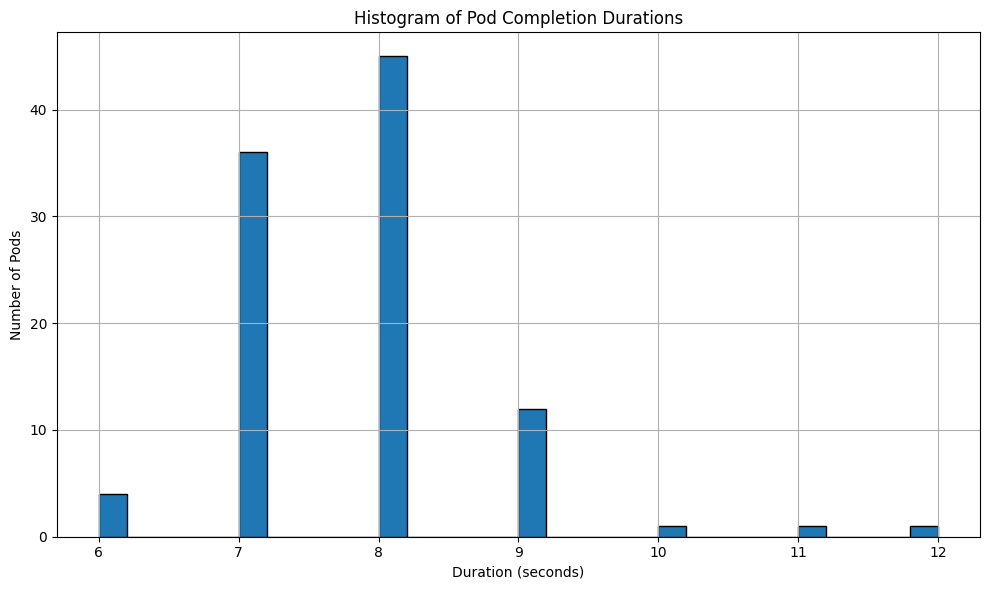

In [23]:
import json
from datetime import datetime
import matplotlib.pyplot as plt

with open("pods1.json") as f:
    data = json.load(f)

durations = []

for pod in data["items"]:
    try:
        name = pod["metadata"]["name"]
        ns = pod["metadata"]["namespace"]
        start = datetime.fromisoformat(pod["status"]["startTime"].replace("Z", "+00:00"))

        # Get first container’s finished time
        cs = pod["status"]["containerStatuses"][0]
        if "terminated" in cs["state"]:
            finish = datetime.fromisoformat(cs["state"]["terminated"]["finishedAt"].replace("Z", "+00:00"))
            duration = (finish - start).total_seconds()
            durations.append(duration)
    except Exception:
        continue

plt.figure(figsize=(10, 6))
plt.hist(durations, bins=30, edgecolor='black')
plt.title("Histogram of Pod Completion Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Pods")
plt.grid(True)
plt.tight_layout()
plt.show()

# Job Completion

In [27]:
!kubectl get jobs -o json > kube-job.json

In [29]:
import json
from datetime import datetime

with open("kube-job.json") as f:
    data = json.load(f)

durations = []

for job in data["items"]:
    try:
        name = job["metadata"]["name"]
        ns = job["metadata"]["namespace"]
        start = datetime.fromisoformat(job["status"]["startTime"].replace("Z", "+00:00"))
        finish = datetime.fromisoformat(job["status"]["completionTime"].replace("Z", "+00:00"))
        duration = (finish - start).total_seconds()
        durations.append((ns, name, duration))
    except KeyError:
        continue  # Job hasn't finished yet

# Print durations
for ns, name, duration in durations:
    print(f"{ns}/{name}: {duration:.2f} seconds")

basic-sched/pi-2000: 14.00 seconds
